## Run MCMC inference using GP model

In [1]:
import random
import time

import tikzplotlib
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro.distributions as npdist
import numpyro
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
import pickle

import jax.config as config
config.update("jax_enable_x64", True)

#from priorCVAE.priors import SquaredExponential, Matern12, Matern52
from priorCVAE.priors import SquaredExponential
from experiments.zimbabwe_utility import read_data

numpyro.set_host_device_count(4)

import yaml
import flax.linen as nn
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params

import os
from os import listdir

from scipy.stats import gaussian_kde

import dill

In [2]:
data_path = "../../zimbabwe/data/zwe2016phia.geojson"

num_warmup = 5000
num_samples = 50000

#num_warmup = 1000
#num_samples = 10000

num_warmup = 10
num_samples = 40
num_chains = 3

kernel_gp = SquaredExponential()

## Load Data

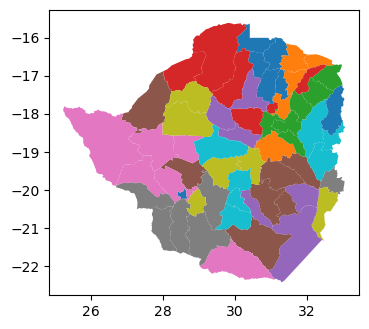

/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/zimbabwe_utility.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


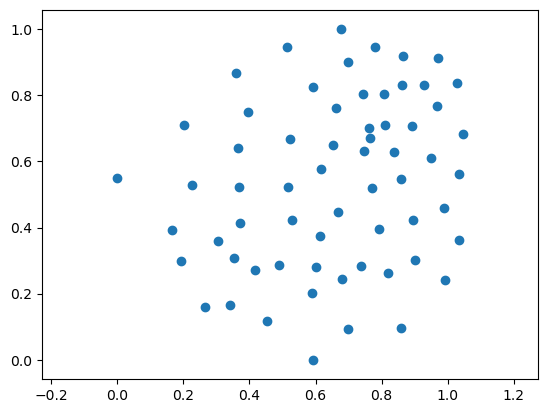

In [3]:
data = gpd.read_file(data_path)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
data.plot(column='area_id', ax=ax, legend=False)

plt.show()

x, data_centroid = read_data(data_path, normalize=True)

plt.scatter(x[:, 1], x[:, 0])
plt.axis("equal")

## Adding estimate data
data_centroid["estimate"] = data["estimate"]

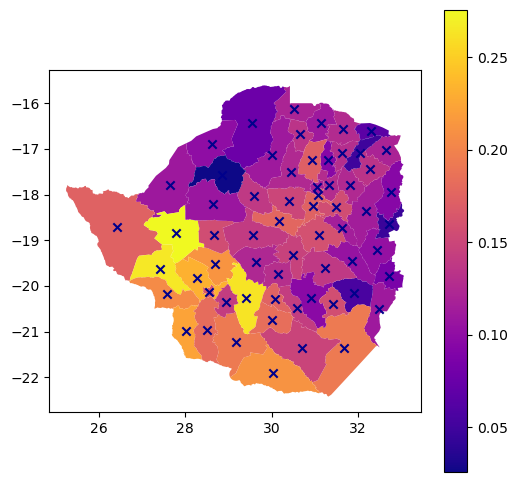

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
data_centroid.plot(column='estimate', ax=ax, legend=True, cmap='plasma')
data_centroid["centroid"].plot(ax=ax, color="DarkBlue", marker="x")
plt.show()

In [5]:
def model_gp(x, n_obs=None, kernel=kernel_gp, lengthscale=None, y=None):
    
    #lengthscale = numpyro.sample("lengthscale", npdist.Gamma(0.4, 2.0)) 
    #lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2.5, 5.0)) 
    lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2.5, 10.0)) 
        
    kernel.lengthscale = lengthscale
    k = kernel(x, x)
    
    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    N = x.shape[0]
    re_std = numpyro.sample('re_std', npdist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=k))
    re = numpyro.deterministic('re', kernel_var * re_std)
    
    # calculated here as it is required later for plotting purposes
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(re))
    
    # Logits transformation happens inside the numpyro distribution.
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=re), obs=y)

## Observations

In [6]:
data['y'] = round(data['y']).astype(int)
data['n_obs'] = round(data['n_obs']).astype(int)

## GP Prior

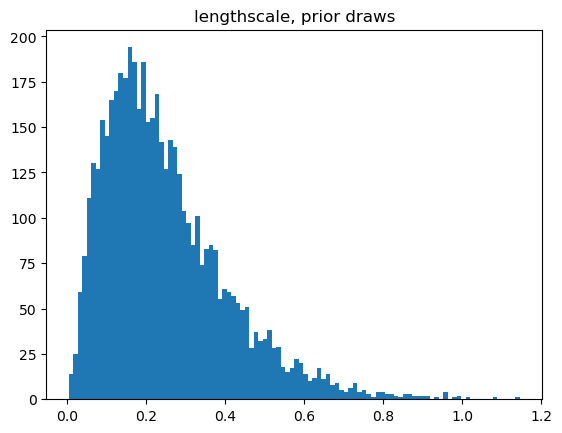

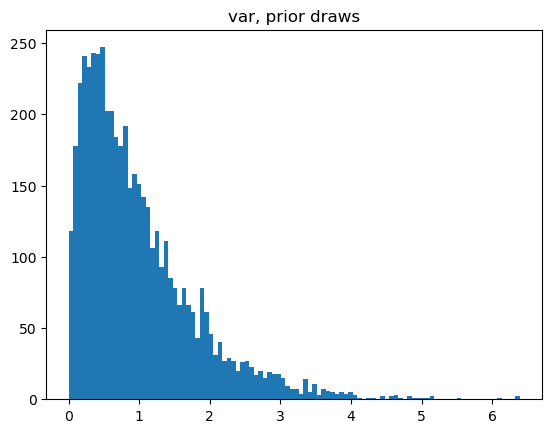

In [7]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))
gp_predictive = Predictive(model_gp, num_samples=5000)
gp_preds = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs))

ls_prior_draws = gp_preds['lengthscale']
plt.hist(ls_prior_draws, bins=100)
plt.title('lengthscale, prior draws')
plt.show()

kernel_var_prior = gp_preds['variance']
plt.hist(kernel_var_prior, bins=100)
plt.title('var, prior draws')
plt.show()

## MCMC Inference using GP Prior

In [8]:
#rng_key = jax.random.PRNGKey(5678)
rng_key = jax.random.PRNGKey(42789789)
rng_key, rng_key_predict = jax.random.split(rng_key)

# inference
start = time.time()
mcmc_gp_model = NUTS(model_gp)
mcmc_gp = MCMC(mcmc_gp_model, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_gp.run(rng_key, x=x, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y), kernel=SquaredExponential())
t_elapsed = time.time() - start

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
mcmc_gp.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.24      0.17      0.18      0.04      0.47       nan     26.14
    re_std[0]     -0.34      0.47     -0.16     -1.27      0.09      7.11      2.59
    re_std[1]      0.19      1.51      1.26     -1.71      1.65      1.74      4.84
    re_std[2]     -1.46      0.45     -1.58     -1.87     -0.93      2.01      2.31
    re_std[3]     -0.42      0.90     -0.57     -1.22      0.80      1.59      8.82
    re_std[4]      0.27      0.62      0.33     -0.23      1.30      4.66      1.84
    re_std[5]     -0.47      0.54     -0.69     -1.18      0.23      1.74      5.77
    re_std[6]     -0.33      0.72      0.08     -1.08      0.68      3.19      2.58
    re_std[7]     -1.08      0.43     -0.98     -1.88     -0.66      1.84      3.63
    re_std[8]      0.91      0.86      0.90     -0.24      1.87      1.85      3.69
    re_std[9]     -0.14      0.35      0.11     -0.47      0.20      3.64  

In [36]:
#fname = 'mcmc_fits/tmp.pkl'

#with open(fname, 'wb') as file:
#    pickle.dump(mcmc_gp, file)

In [37]:
os.getcwd()

'/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/notebooks/zimbabwe'

In [10]:
#fname = 'mcmc_fits/zimbabwe_gp_mcmc_RBF_normalised_Gamma_{}iter.pkl'.format(num_samples)

#with open(fname, 'wb') as f:
#    dill.dump(mcmc_gp, f)

#with open(path + 'mcmc1.pkl', 'rb') as f:
#    mcmc1 = dill.load(f)

In [11]:
#fname = 'mcmc_fits/zimbabwe_gp_mcmc_RBF_normalised_Gamma_{}iter.pkl'.format(num_samples)

# Save trained MCMC model
#with open(fname, 'wb') as file:
#    pickle.dump(mcmc_gp, file)

In [12]:
mcmc_gp.print_summary(exclude_deterministic=True)
mcmc_gp_samples = mcmc_gp.get_samples()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.35      0.02      0.35      0.33      0.38      1.75      1.56
    re_std[0]     -1.21      0.17     -1.18     -1.40     -1.03      1.01     13.68
    re_std[1]     -1.45      0.19     -1.45     -1.66     -1.24      1.00     23.56
    re_std[2]     -1.46      0.20     -1.45     -1.67     -1.24      1.00     25.70
    re_std[3]     -1.70      0.28     -1.68     -2.00     -1.41      1.00     17.10
    re_std[4]     -1.81      0.33     -1.76     -2.21     -1.43      1.02      8.77
    re_std[5]     -1.62      0.31     -1.57     -2.03     -1.26      1.03      6.53
    re_std[6]     -1.72      0.26     -1.68     -2.05     -1.44      1.02     13.09
    re_std[7]     -1.81      0.31     -1.78     -2.15     -1.49      1.00     14.69
    re_std[8]     -1.83      0.33     -1.78     -2.23     -1.47      1.02     10.01
    re_std[9]     -1.82      0.35     -1.76     -2.31     -1.42      1.06  

In [13]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
r = jnp.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 9118 s
Average ESS for all REs : 4


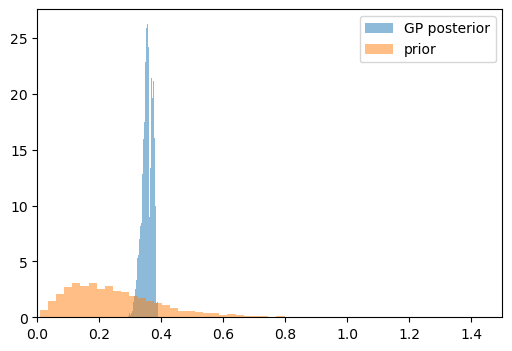

In [14]:
c_samps_gp = mcmc_gp_samples['lengthscale']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_gp, density=True, label = 'GP posterior', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('lengthscale, prior and posterior')
plt.legend()
plt.xlim([0, 1.5])

#tikzplotlib.save(r"lengthscale.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)

plt.show()

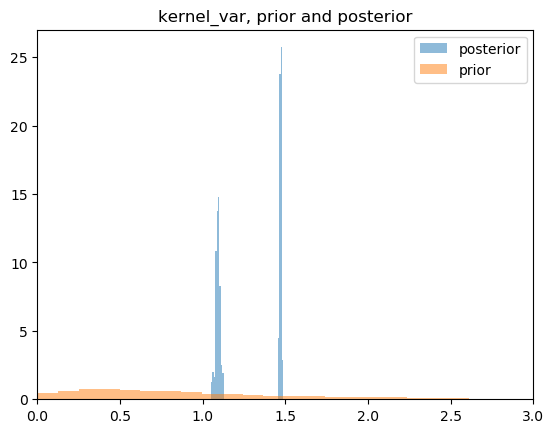

In [15]:
var_samps_gp = mcmc_gp_samples['variance']
plt.hist(var_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'prior', bins=50, alpha=0.5)
plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

# tikzplotlib.save(r"variance.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)

plt.show()

(24.8460406, 33.4588074, -22.7626307, -15.268733300000001)

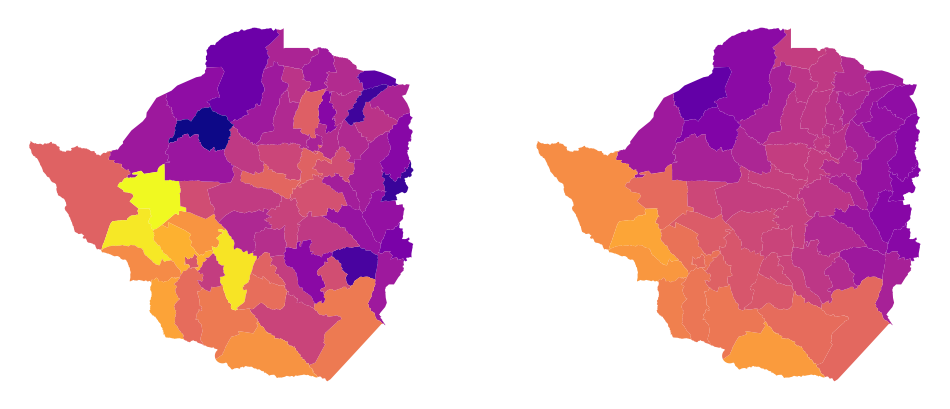

In [16]:
# posterior predictive
posterior_predictive_gp = Predictive(model_gp, mcmc_gp_samples)(jax.random.PRNGKey(random.randint(0, 9999)), 
                                                                         x=x, 
                                                                         n_obs = jnp.array(data.n_obs))


theta_samps_gp = posterior_predictive_gp['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = jnp.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = jnp.quantile(theta_samps_gp, 0.75, axis=0)

data['theta_gp'] = theta_mean_gp

theta_observed = jnp.array(data['estimate'])
theta_estimated_gp = jnp.array(data['theta_gp'])

_max = np.max([theta_observed, theta_estimated_gp])
_min = np.min([theta_observed, theta_estimated_gp])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
data.plot(column="estimate", ax=ax[0], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

ax[0].axis("off")
ax[1].axis("off")

In [17]:
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

#plt.axis("off")
#plt.tight_layout()
#plt.savefig("estimate.pdf")
#plt.show()

In [18]:
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#data.plot(column="theta_gp", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

#plt.axis("off")
#plt.tight_layout()
#plt.savefig("gp_inference.pdf")
#plt.show()

## Define model - PriorCVAE

In [12]:
#outputs_path = "../../outputs/"
#outputs_path = "../../outputs/outputs_90jobs"
outputs_path = "../../outputs/outputs_rbf_normalized"

from os import listdir

print(listdir(outputs_path))

print(len(listdir(outputs_path)))

['2024-02-07', 'efynxet1', 'vdqtcltt', 'lad3r4vv', '02g2lize', '6h5h7tzw', '2024-02-06', '7yi0j5wg', 'h7n950lp', 'teg57g7c', 'usm3gmln', 'luq5pyjh', '2mfieep0', 'qerrqzvc', 'n7djdwpv', '0jx5y3iw', 'i1ayn414', 'ykth1iax', 'bfjv1o6o', 'iferpucb', '878nuaz6', '6abkw9fm', '5r3pr1d1', '2kqd3c1w', 'zdb1spgj', 'evsqvv14', 'plfbtoh5', 'wjfj0cw7', '8rivtsgl', '5sv12yb1', 'x32jyqx0', 'ud0zna7j', '45qydp3s', 'a67ri9kk', 't8v53i5n', 'idcc4bpi', 'ihfceefj', 'pc4cgvrc', 'yhbbpxjw', '2w6t5ih9', 'z3u9eb8a', 'haaf4dm6', 'pyvev513', 'y1w9nusg']
44


In [13]:
#data_path = "../../zimbabwe/data/zwe2016phia.geojson"

dirs = listdir(outputs_path) 
#dirs = ["6dv9hm9r", "c9olhh5v", "fvk8l9r1", "vmp2r78b", "yzgfmgh6"]


dir_paths = ["../../outputs/outputs_rbf_normalized/" + dirs[i] for i in range(len(dirs))]
dir_paths = [item for item in dir_paths if '.DS_Store' not in item]
dir_paths = [item for item in dir_paths if '2024-' not in item]

#dir_paths = ["../../outputs/" + dirs[i] for i in range(len(dirs))]
#dir_paths = ["../../outputs/outputs_90jobs/" + dirs[i] for i in range(len(dirs))]
#dir_paths = [item for item in dir_paths if '.DS_Store' not in item]

#dir_paths = ["../../outputs/an8xbohc"]
dir_paths

['../../outputs/outputs_rbf_normalized/efynxet1',
 '../../outputs/outputs_rbf_normalized/vdqtcltt',
 '../../outputs/outputs_rbf_normalized/lad3r4vv',
 '../../outputs/outputs_rbf_normalized/02g2lize',
 '../../outputs/outputs_rbf_normalized/6h5h7tzw',
 '../../outputs/outputs_rbf_normalized/7yi0j5wg',
 '../../outputs/outputs_rbf_normalized/h7n950lp',
 '../../outputs/outputs_rbf_normalized/teg57g7c',
 '../../outputs/outputs_rbf_normalized/usm3gmln',
 '../../outputs/outputs_rbf_normalized/luq5pyjh',
 '../../outputs/outputs_rbf_normalized/2mfieep0',
 '../../outputs/outputs_rbf_normalized/qerrqzvc',
 '../../outputs/outputs_rbf_normalized/n7djdwpv',
 '../../outputs/outputs_rbf_normalized/0jx5y3iw',
 '../../outputs/outputs_rbf_normalized/i1ayn414',
 '../../outputs/outputs_rbf_normalized/ykth1iax',
 '../../outputs/outputs_rbf_normalized/bfjv1o6o',
 '../../outputs/outputs_rbf_normalized/iferpucb',
 '../../outputs/outputs_rbf_normalized/878nuaz6',
 '../../outputs/outputs_rbf_normalized/6abkw9fm',


In [14]:
#output_dir = "../../outputs/6dv9hm9r"
#data_path = "../../zimbabwe/data/zwe2016phia.geojson"
#n_samples = 5000

In [15]:
def model_cvae(trained_decoder_params, latent_dim, n_obs=None, lengthscale=None, y=None):
    
    #lengthscale = numpyro.sample("lengthscale", npdist.Gamma(0.4, 2.0)) 
    lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2.5, 10.0)) 

    c = jnp.array([lengthscale])

    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    
    z = numpyro.sample("z", npdist.Normal(jnp.zeros(latent_dim), jnp.ones(latent_dim)))
    z = jnp.concatenate([z, c]) 
    f = numpyro.deterministic('f', decoder.apply({'params': trained_decoder_params}, z))
     
    re = numpyro.deterministic('re', kernel_var * f)
    
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(re))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=re), obs=y)

In [24]:
#fname = 'mcmc_fits/tmp.pkl'

#with open(fname, 'wb') as file:
#    pickle.dump(mcmc_cvae, file)

In [16]:
c_samps_cvae_lst = []

for i in range(len(dir_paths)):
    print(i)
    output_dir = dir_paths[i]
    print(output_dir)
    cfg_path = os.path.join(output_dir, "files", "config.yaml")
    with open(cfg_path, 'r') as file:
        cfg_data = yaml.safe_load(file)

    conditional = cfg_data["conditional"]['value']
    latent_dim = cfg_data["latent_dim"]['value']
    normalize = cfg_data["normalize"]['value']
    dec_activation_fn = cfg_data["dec_activation"]['value']["_target_"]
    dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

    trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]
    output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
    hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
    decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

    rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

    # inference
    start = time.time()
    kernel = NUTS(model_cvae)
    mcmc_cvae = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc_cvae.run(rng_key, trained_decoder_params, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y))
    t_elapsed = time.time() - start
    print(t_elapsed)

    mcmc_cvae.print_summary(exclude_deterministic=True)

    mcmc_cvae_samples = mcmc_cvae.get_samples()

    c_samps_cvae = mcmc_cvae_samples['lengthscale']

    c_samps_cvae_lst.append(c_samps_cvae)

0
../../outputs/outputs_rbf_normalized/efynxet1


  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

34.35146617889404

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.34      0.05      0.34      0.25      0.41   5337.29      1.00
     variance      1.61      0.45      1.53      0.93      2.27  13861.51      1.00
         z[0]      0.07      0.99      0.08     -1.51      1.75  94737.22      1.00
         z[1]      0.10      0.99      0.10     -1.53      1.72  92962.61      1.00
         z[2]     -0.03      1.01     -0.04     -1.68      1.62  97093.33      1.00
         z[3]      0.21      1.00      0.21     -1.45      1.84  93039.69      1.00
         z[4]     -0.28      1.00     -0.28     -1.90      1.38  95986.71      1.00
         z[5]      0.18      0.96      0.18     -1.38      1.78  88602.71      1.00
         z[6]     -0.60      0.84     -0.59     -1.97      0.79  53167.72      1.00
         z[7]      0.02      1.00      0.02     -1.66      1.62  98593.29      1.00
         z[8]      0.25      0.99      0.25     -1.37    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

18.3340060710907

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.13      0.17      1.11      0.85      1.40  41801.37      1.00
     variance      4.81      1.12      4.70      3.03      6.58  31200.55      1.00
         z[0]     -0.33      0.99     -0.33     -1.95      1.30 120647.90      1.00
         z[1]     -0.31      0.97     -0.31     -1.90      1.28 114736.81      1.00
         z[2]     -0.39      0.98     -0.39     -2.02      1.19 123250.53      1.00
         z[3]      0.51      0.98      0.51     -1.11      2.12 126105.00      1.00
         z[4]     -0.24      0.99     -0.24     -1.90      1.36 116117.63      1.00
         z[5]      0.06      0.98      0.06     -1.57      1.68 134346.95      1.00
         z[6]      0.35      0.99      0.35     -1.25      2.01 114650.25      1.00
         z[7]      0.15      0.99      0.15     -1.50      1.74 127055.03      1.00
         z[8]      0.07      0.06      0.07     -0.03     

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

18.372867822647095

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.00      0.16      0.98      0.77      1.24  17410.58      1.00
     variance      2.56      0.71      2.49      1.40      3.65  15391.45      1.00
         z[0]      0.02      1.00      0.01     -1.63      1.64  91963.52      1.00
         z[1]      0.07      1.01      0.08     -1.59      1.71  88056.01      1.00
         z[2]      0.31      1.00      0.31     -1.33      1.95  86011.49      1.00
         z[3]      0.05      0.99      0.05     -1.58      1.67  99962.44      1.00
         z[4]      0.07      1.00      0.06     -1.55      1.72  87914.60      1.00
         z[5]      0.03      0.99      0.03     -1.61      1.66  94793.29      1.00
         z[6]      0.22      1.00      0.22     -1.41      1.87  84795.98      1.00
         z[7]     -0.00      1.00     -0.00     -1.67      1.61  96648.64      1.00
         z[8]     -0.05      1.01     -0.05     -1.76   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

19.907771825790405

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.22      0.09      0.23      0.09      0.35   8648.58      1.00
     variance      1.07      0.24      1.03      0.70      1.42  11818.86      1.00
         z[0]     -0.02      1.00     -0.02     -1.66      1.62 101776.81      1.00
         z[1]      0.06      1.00      0.05     -1.63      1.67 100743.50      1.00
         z[2]     -0.17      0.13     -0.17     -0.39      0.05  59666.70      1.00
         z[3]     -0.08      1.00     -0.08     -1.74      1.54  90761.79      1.00
         z[4]     -0.04      1.00     -0.04     -1.72      1.56  88623.65      1.00
         z[5]     -1.73      0.38     -1.72     -2.34     -1.10  12699.44      1.00
         z[6]     -0.04      0.99     -0.04     -1.70      1.57  96200.34      1.00
         z[7]     -0.07      1.00     -0.07     -1.70      1.58  94912.77      1.00
         z[8]      0.02      1.00      0.02     -1.66   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

35.67562413215637

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.81      0.10      0.81      0.65      0.97   9113.71      1.00
     variance      2.03      1.02      1.80      0.67      3.50    330.20      1.01
         z[0]     -0.00      0.99     -0.01     -1.65      1.61  22726.40      1.00
         z[1]     -0.19      1.01     -0.20     -1.85      1.47  20321.80      1.00
         z[2]     -0.06      1.00     -0.05     -1.70      1.59  10242.10      1.00
         z[3]      0.16      1.00      0.15     -1.46      1.84  26150.71      1.00
         z[4]     -0.01      1.00     -0.00     -1.65      1.64  83354.09      1.00
         z[5]      0.15      0.99      0.17     -1.44      1.83  37965.03      1.00
         z[6]     -0.02      1.01     -0.02     -1.60      1.67   2774.93      1.00
         z[7]      0.11      0.99      0.12     -1.52      1.75  75381.78      1.00
         z[8]     -0.04      0.99     -0.05     -1.68    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

21.21350908279419

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.35      0.05      0.35      0.26      0.43   5562.86      1.00
     variance      1.33      0.45      1.21      0.72      1.99   6021.29      1.00
         z[0]      0.01      1.00      0.01     -1.64      1.65  82530.96      1.00
         z[1]      0.00      1.00      0.00     -1.66      1.62  91767.11      1.00
         z[2]     -0.05      1.00     -0.05     -1.72      1.57  81352.40      1.00
         z[3]      0.27      0.10      0.26      0.11      0.43  11608.96      1.00
         z[4]      0.04      1.01      0.04     -1.63      1.66  93537.70      1.00
         z[5]      0.06      1.00      0.06     -1.56      1.74  75549.36      1.00
         z[6]     -0.03      1.00     -0.03     -1.65      1.64  75160.58      1.00
         z[7]     -0.02      1.00     -0.02     -1.69      1.60  98168.37      1.00
         z[8]      0.03      1.00      0.03     -1.66    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

20.41220712661743

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.36      0.16      0.33      0.23      0.41     17.66      1.09
     variance      1.64      0.59      1.50      0.86      2.39     79.76      1.03
         z[0]      0.30      1.00      0.31     -1.35      1.94  60057.73      1.00
         z[1]      0.04      1.00      0.04     -1.60      1.67  75831.66      1.00
         z[2]      0.10      0.08      0.09     -0.02      0.22    518.73      1.01
         z[3]     -0.13      0.24     -0.16     -0.36      0.01     23.69      1.06
         z[4]      0.25      0.99      0.25     -1.41      1.85  72473.18      1.00
         z[5]      0.12      1.00      0.12     -1.53      1.75  71091.59      1.00
         z[6]     -0.18      1.00     -0.17     -1.83      1.45  74825.13      1.00
         z[7]     -0.05      1.00     -0.05     -1.70      1.60  74711.65      1.00
         z[8]     -0.16      0.98     -0.17     -1.79    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

32.57901620864868

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.35      0.07      0.37      0.25      0.45   3457.65      1.00
     variance      1.42      0.53      1.33      0.67      2.19   5482.10      1.00
         z[0]     -0.02      1.00     -0.02     -1.70      1.59  78683.08      1.00
         z[1]      0.05      0.94      0.09     -1.47      1.64  32673.71      1.00
         z[2]     -0.13      1.00     -0.13     -1.78      1.51  76438.04      1.00
         z[3]      1.43      0.44      1.37      0.75      2.12   4669.64      1.00
         z[4]      0.07      1.01      0.07     -1.56      1.74  77198.53      1.00
         z[5]     -0.05      1.00     -0.04     -1.70      1.57  80567.41      1.00
         z[6]     -0.02      1.00     -0.02     -1.69      1.59  76003.94      1.00
         z[7]     -0.04      1.00     -0.04     -1.72      1.57  81901.61      1.00
         z[8]      0.01      1.00      0.01     -1.64    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

32.981329917907715

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.10      0.13      1.09      0.91      1.30  19661.34      1.00
     variance      3.75      1.07      3.65      2.03      5.46  19480.00      1.00
         z[0]     -0.51      0.96     -0.51     -2.07      1.09  84123.27      1.00
         z[1]     -0.08      0.08     -0.08     -0.21      0.04  33603.98      1.00
         z[2]      0.04      1.00      0.04     -1.61      1.65  95813.74      1.00
         z[3]     -0.09      0.98     -0.09     -1.71      1.52  85779.15      1.00
         z[4]      0.30      0.99      0.30     -1.32      1.93  84150.92      1.00
         z[5]     -0.08      0.99     -0.09     -1.71      1.52  81075.55      1.00
         z[6]      0.18      0.99      0.18     -1.45      1.77  87085.97      1.00
         z[7]     -0.47      0.99     -0.47     -2.11      1.13  87421.21      1.00
         z[8]     -0.49      0.99     -0.49     -2.10   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

21.03515601158142

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.26      0.16      1.24      1.01      1.51  29353.21      1.00
     variance      2.94      0.83      2.84      1.65      4.24  15254.64      1.00
         z[0]      0.26      0.99      0.26     -1.41      1.83  81776.13      1.00
         z[1]      0.25      0.99      0.25     -1.32      1.93  77863.62      1.00
         z[2]      0.17      0.99      0.17     -1.44      1.80  71808.55      1.00
         z[3]      0.33      1.00      0.32     -1.29      1.98  76010.62      1.00
         z[4]      0.53      0.73      0.52     -0.67      1.73  50650.78      1.00
         z[5]     -0.18      0.99     -0.18     -1.81      1.44  76478.47      1.00
         z[6]     -0.14      0.99     -0.14     -1.83      1.43  79652.53      1.00
         z[7]     -0.22      0.94     -0.23     -1.76      1.34  70420.45      1.00
         z[8]      0.32      0.99      0.32     -1.32    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

19.906851053237915

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.37      0.09      0.37      0.29      0.43    161.98      1.01
     variance      1.50      0.47      1.41      0.84      2.14   1147.94      1.00
         z[0]     -1.83      0.46     -1.80     -2.57     -1.08   2343.98      1.00
         z[1]     -0.27      0.09     -0.26     -0.41     -0.12   7188.16      1.00
         z[2]      0.20      0.97      0.20     -1.39      1.80  38791.78      1.00
         z[3]      0.02      1.00      0.02     -1.64      1.66  62617.24      1.00
         z[4]      0.02      1.00      0.03     -1.65      1.62  67565.98      1.00
         z[5]      1.24      0.45      1.18      0.56      1.93  13362.50      1.00
         z[6]      0.13      0.90      0.15     -1.39      1.57  33441.30      1.00
         z[7]     -0.91      0.93     -0.94     -2.46      0.60  16329.57      1.00
         z[8]      0.01      1.00      0.01     -1.61   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

16.794401168823242

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.08      0.45      1.22      0.29      1.57      8.31      1.16
     variance      3.80      1.40      3.81      1.03      5.68    352.11      1.01
         z[0]      0.03      0.99      0.03     -1.67      1.60  73983.62      1.00
         z[1]      0.18      1.00      0.18     -1.44      1.84   4897.85      1.00
         z[2]     -0.03      1.00     -0.03     -1.69      1.61  69504.56      1.00
         z[3]     -0.05      1.01     -0.05     -1.72      1.59  13617.53      1.00
         z[4]      0.09      1.00      0.10     -1.58      1.72  62992.00      1.00
         z[5]     -0.75      0.82     -0.77     -2.16      0.59  17692.02      1.00
         z[6]     -0.16      0.28     -0.16     -0.60      0.31    801.72      1.00
         z[7]     -0.10      0.97     -0.10     -1.70      1.49  60936.74      1.00
         z[8]     -0.13      0.89     -0.13     -1.61   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

20.807914972305298

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.34      0.10      0.37      0.16      0.47   6056.00      1.00
     variance      1.21      0.30      1.15      0.78      1.65  13023.53      1.00
         z[0]      0.00      1.00      0.00     -1.63      1.65  67557.23      1.00
         z[1]      0.36      0.47      0.36     -0.33      1.23  23445.35      1.00
         z[2]      0.03      1.00      0.03     -1.62      1.67  71437.16      1.00
         z[3]     -0.08      0.12     -0.08     -0.27      0.11  50133.39      1.00
         z[4]     -0.04      1.00     -0.04     -1.67      1.62  63245.92      1.00
         z[5]      0.06      0.99      0.06     -1.55      1.70  67588.56      1.00
         z[6]     -0.02      1.00     -0.02     -1.65      1.63  69390.52      1.00
         z[7]     -0.00      1.00     -0.00     -1.65      1.63  69193.97      1.00
         z[8]     -0.01      1.00     -0.00     -1.66   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

17.280282974243164

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.37      0.25      1.36      1.00      1.79   6554.24      1.00
     variance      2.70      0.73      2.61      1.55      3.83  18779.51      1.00
         z[0]      1.64      0.73      1.62      0.44      2.84  21257.09      1.00
         z[1]      0.18      1.00      0.18     -1.49      1.80  93203.03      1.00
         z[2]      0.15      0.99      0.16     -1.46      1.78  89179.60      1.00
         z[3]      0.04      0.99      0.03     -1.56      1.68  96335.30      1.00
         z[4]     -0.04      0.99     -0.04     -1.66      1.59  90854.97      1.00
         z[5]     -0.22      1.00     -0.22     -1.87      1.42  91274.69      1.00
         z[6]     -0.08      0.99     -0.08     -1.71      1.56  91044.82      1.00
         z[7]      0.12      0.96      0.12     -1.46      1.70  94425.77      1.00
         z[8]     -0.11      1.00     -0.10     -1.75   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

45.56039500236511

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.77      0.05      0.76      0.69      0.84  25280.26      1.00
     variance      4.09      1.04      3.97      2.46      5.71  22098.01      1.00
         z[0]     -0.33      0.99     -0.33     -1.97      1.30  97297.36      1.00
         z[1]     -0.38      1.00     -0.37     -2.07      1.23  90765.54      1.00
         z[2]      0.29      0.99      0.29     -1.31      1.94  98451.33      1.00
         z[3]     -0.22      1.00     -0.22     -1.83      1.46  97341.22      1.00
         z[4]      0.10      0.99      0.10     -1.51      1.73  99231.62      1.00
         z[5]      0.68      0.98      0.68     -0.97      2.26 104410.51      1.00
         z[6]     -0.13      0.99     -0.14     -1.77      1.49 102641.37      1.00
         z[7]     -0.18      0.98     -0.18     -1.78      1.43 103944.48      1.00
         z[8]     -0.65      1.00     -0.65     -2.25    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

17.08500385284424

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.81      0.10      0.80      0.66      0.97  43353.89      1.00
     variance      1.38      0.44      1.30      0.72      2.01  23980.49      1.00
         z[0]     -0.01      1.00     -0.01     -1.62      1.66  82969.89      1.00
         z[1]     -0.15      1.00     -0.15     -1.80      1.48  80219.17      1.00
         z[2]     -0.07      1.00     -0.07     -1.74      1.55  84617.76      1.00
         z[3]      0.07      1.00      0.07     -1.57      1.74  84882.11      1.00
         z[4]     -0.10      1.00     -0.10     -1.73      1.54  79484.84      1.00
         z[5]     -0.07      1.00     -0.07     -1.66      1.62  83084.51      1.00
         z[6]      0.13      1.00      0.13     -1.47      1.81  85506.84      1.00
         z[7]     -0.01      1.01     -0.01     -1.64      1.68  81966.56      1.00
         z[8]      0.13      1.01      0.13     -1.50    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

26.904006958007812

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.68      0.15      0.74      0.48      0.87      6.82      1.52
     variance      4.62      2.37      4.32      1.37      8.01      8.44      1.39
         z[0]      0.61      1.01      0.62     -1.08      2.24    112.15      1.02
         z[1]     -0.03      0.45     -0.02     -0.76      0.68  18650.97      1.00
         z[2]      0.58      1.00      0.59     -1.07      2.24    688.18      1.01
         z[3]     -2.56      0.83     -2.58     -3.89     -1.16     17.27      1.15
         z[4]     -0.63      0.38     -0.49     -1.19     -0.19      9.07      1.35
         z[5]      0.31      1.01      0.32     -1.37      1.95    216.90      1.01
         z[6]      1.50      0.94      1.52     -0.05      3.04  17262.40      1.00
         z[7]     -0.09      0.99     -0.10     -1.73      1.52  79292.34      1.00
         z[8]      0.28      1.02      0.28     -1.41   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

31.86738109588623

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.16      0.17      1.15      0.88      1.44   9304.15      1.00
     variance      3.23      1.42      2.95      1.14      5.31   2264.09      1.00
         z[0]      0.04      0.99      0.04     -1.57      1.68  35717.68      1.00
         z[1]      0.17      1.00      0.17     -1.50      1.78  43404.52      1.00
         z[2]     -0.04      1.00     -0.04     -1.73      1.55  59810.66      1.00
         z[3]     -0.06      1.01     -0.07     -1.73      1.57  16263.73      1.00
         z[4]      0.02      0.99      0.01     -1.61      1.65  42804.38      1.00
         z[5]     -0.07      1.01     -0.08     -1.70      1.61  55109.56      1.00
         z[6]     -0.65      1.00     -0.65     -2.33      0.98  32565.40      1.00
         z[7]      0.44      0.99      0.44     -1.23      2.04  58501.10      1.00
         z[8]     -0.18      0.38     -0.15     -0.80    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

35.66658401489258

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.79      0.12      0.78      0.59      0.99   3388.40      1.00
     variance      5.10      2.57      4.45      1.38      9.17   1402.45      1.00
         z[0]     -0.07      1.00     -0.06     -1.71      1.60  38259.39      1.00
         z[1]     -0.04      1.00     -0.04     -1.70      1.61  43795.45      1.00
         z[2]      0.55      0.32      0.49      0.14      0.92   2600.11      1.00
         z[3]     -0.13      1.06     -0.12     -1.89      1.61   5112.26      1.00
         z[4]      0.18      1.01      0.18     -1.48      1.84  25707.14      1.00
         z[5]      0.12      0.98      0.11     -1.54      1.69  63699.66      1.00
         z[6]      0.25      1.02      0.25     -1.44      1.91   9871.64      1.00
         z[7]     -0.40      1.03     -0.40     -2.11      1.26   7882.65      1.00
         z[8]     -0.22      1.17     -0.17     -2.15    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

33.647704124450684

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.08      0.11      1.07      0.91      1.24  22468.31      1.00
     variance      3.66      1.25      3.47      1.65      5.46  17158.97      1.00
         z[0]     -0.13      0.96     -0.13     -1.74      1.43  91353.74      1.00
         z[1]     -0.11      1.01     -0.11     -1.76      1.54  95343.78      1.00
         z[2]     -0.07      0.99     -0.07     -1.73      1.53  95138.31      1.00
         z[3]     -0.19      0.99     -0.19     -1.80      1.48  89912.07      1.00
         z[4]     -0.10      1.00     -0.10     -1.75      1.53  94093.95      1.00
         z[5]      0.05      1.00      0.05     -1.58      1.70  93445.25      1.00
         z[6]     -0.05      0.99     -0.05     -1.66      1.59  94305.00      1.00
         z[7]      0.27      1.00      0.27     -1.34      1.94  96417.61      1.00
         z[8]      0.23      0.99      0.23     -1.41   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

45.29300808906555

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.86      0.10      0.85      0.69      1.02   6179.75      1.00
     variance      4.26      2.08      4.01      0.80      7.24    473.12      1.01
         z[0]      0.11      1.00      0.08     -1.57      1.71   3734.54      1.00
         z[1]      0.09      0.98      0.11     -1.53      1.69   4552.96      1.00
         z[2]     -0.19      1.02     -0.21     -1.93      1.42   1028.68      1.01
         z[3]     -0.06      1.00     -0.06     -1.67      1.60   5676.82      1.00
         z[4]     -0.50      0.97     -0.50     -2.12      1.06  21369.02      1.00
         z[5]     -0.18      1.01     -0.18     -1.85      1.43   1991.75      1.00
         z[6]     -0.15      0.97     -0.15     -1.76      1.44  18522.87      1.00
         z[7]      0.07      1.00      0.07     -1.54      1.69   2374.39      1.00
         z[8]      0.18      1.00      0.19     -1.39    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

13.78589916229248

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.75      0.09      0.73      0.60      0.88  31792.63      1.00
     variance      1.25      0.41      1.15      0.68      1.83   9507.75      1.00
         z[0]     -0.03      0.99     -0.03     -1.68      1.58  85252.51      1.00
         z[1]      0.13      0.99      0.13     -1.53      1.71  90438.76      1.00
         z[2]      0.07      1.00      0.08     -1.55      1.73  86872.24      1.00
         z[3]     -0.09      1.00     -0.09     -1.78      1.52  66282.82      1.00
         z[4]     -0.02      1.00     -0.01     -1.67      1.63  93941.24      1.00
         z[5]      0.05      1.00      0.05     -1.60      1.71  94220.15      1.00
         z[6]      0.09      1.00      0.09     -1.54      1.74  86461.75      1.00
         z[7]     -0.02      1.00     -0.02     -1.63      1.66  98757.09      1.00
         z[8]     -0.08      1.00     -0.08     -1.74    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

15.080281972885132

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.40      0.40      0.29      0.00      0.86      1.01      7.21
     variance      5.78      4.87      5.19      0.56     11.69      1.02      5.38
         z[0]     -1.10      1.36     -1.14     -3.27      1.15      1.50      1.54
         z[1]      0.28      0.99      0.29     -1.36      1.88     80.65      1.01
         z[2]      0.03      0.97      0.03     -1.51      1.69  72005.67      1.00
         z[3]     -0.76      1.23     -0.78     -2.77      1.26      1.86      1.34
         z[4]      1.02      1.29      1.07     -1.07      3.10      1.57      1.48
         z[5]     -0.14      1.04     -0.15     -1.87      1.53      7.61      1.05
         z[6]      0.31      1.02      0.32     -1.41      1.95      8.82      1.05
         z[7]      0.78      1.10      0.81     -1.07      2.56      2.39      1.22
         z[8]      0.40      1.99     -0.16     -1.80   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

19.032982110977173

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.80      0.03      0.80      0.75      0.85  11932.42      1.00
     variance      6.70      1.62      6.72      3.98      9.29  11416.80      1.00
         z[0]     -0.52      1.00     -0.52     -2.18      1.10  67571.92      1.00
         z[1]     -0.40      0.99     -0.40     -2.05      1.24  74161.10      1.00
         z[2]      0.10      0.03      0.10      0.05      0.15   9669.79      1.00
         z[3]      0.28      1.00      0.28     -1.35      1.93  69028.26      1.00
         z[4]     -0.69      0.94     -0.69     -2.22      0.86  66498.05      1.00
         z[5]      0.22      0.97      0.21     -1.38      1.82  72830.34      1.00
         z[6]     -0.26      1.01     -0.27     -1.96      1.37  52080.15      1.00
         z[7]     -0.20      0.61     -0.22     -1.21      0.79  30779.66      1.00
         z[8]      1.31      0.96      1.31     -0.25   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

30.102561950683594

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.08      0.16      1.05      0.84      1.34     75.20      1.05
     variance      3.85      2.68      2.61      0.94      8.85      9.39      1.33
         z[0]      0.51      0.93      0.59     -1.09      1.96    173.83      1.01
         z[1]     -0.03      0.99     -0.04     -1.71      1.58    100.46      1.02
         z[2]     -0.37      1.11     -0.33     -2.36      1.21     17.79      1.14
         z[3]     -0.20      0.93     -0.16     -1.81      1.31   1394.18      1.00
         z[4]     -0.74      0.44     -0.72     -1.32     -0.16     21.02      1.13
         z[5]     -0.05      1.02     -0.07     -1.62      1.49     20.18      1.10
         z[6]      0.05      1.11      0.07     -1.83      1.84     17.77      1.10
         z[7]     -0.15      0.92     -0.08     -1.68      1.37    442.99      1.01
         z[8]      0.10      0.93      0.12     -1.44   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

34.68017888069153

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.93      0.21      0.95      0.50      1.20     50.79      1.04
     variance      2.47      1.17      2.19      0.86      4.18    293.53      1.01
         z[0]     -0.10      1.00     -0.10     -1.75      1.53   6194.66      1.00
         z[1]      0.41      0.24      0.37      0.07      0.74    118.07      1.02
         z[2]     -0.14      1.00     -0.13     -1.75      1.52  67081.04      1.00
         z[3]     -0.40      1.00     -0.40     -2.02      1.26  85093.82      1.00
         z[4]      0.13      1.01      0.13     -1.52      1.78  35418.16      1.00
         z[5]      0.03      0.99      0.03     -1.58      1.67  12783.98      1.00
         z[6]      0.30      1.00      0.31     -1.34      1.93  85037.12      1.00
         z[7]     -0.50      0.75     -0.48     -1.72      0.74    146.77      1.01
         z[8]     -0.00      1.01      0.00     -1.61    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

23.232419967651367

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.15      0.18      1.13      0.87      1.43  15522.93      1.00
     variance      2.40      0.88      2.24      1.07      3.65   9305.89      1.00
         z[0]     -0.31      0.93     -0.31     -1.86      1.19  64764.92      1.00
         z[1]      0.24      1.00      0.24     -1.35      1.95  64831.34      1.00
         z[2]     -0.01      0.98     -0.01     -1.64      1.58  58224.22      1.00
         z[3]      1.45      0.77      1.44      0.20      2.73  49072.46      1.00
         z[4]     -0.11      1.00     -0.11     -1.76      1.54  72594.29      1.00
         z[5]      0.13      0.99      0.13     -1.50      1.76  68314.05      1.00
         z[6]      0.29      1.00      0.28     -1.36      1.93  72392.50      1.00
         z[7]     -0.32      0.98     -0.32     -1.90      1.34  70050.61      1.00
         z[8]      0.25      0.99      0.26     -1.34   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

27.431042909622192

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.02      0.13      1.00      0.84      1.22   8826.87      1.00
     variance      3.80      1.74      3.51      1.21      6.46   2580.38      1.00
         z[0]     -0.60      0.32     -0.51     -1.09     -0.19   6527.25      1.00
         z[1]     -0.63      1.02     -0.64     -2.30      1.04  27883.23      1.00
         z[2]     -0.47      1.01     -0.47     -2.12      1.19  13308.33      1.00
         z[3]     -0.18      0.98     -0.18     -1.76      1.48  33781.92      1.00
         z[4]      0.68      0.99      0.68     -0.95      2.29  13925.88      1.00
         z[5]     -0.18      0.99     -0.18     -1.79      1.43  22534.71      1.00
         z[6]     -1.09      1.00     -1.10     -2.77      0.53  26841.61      1.00
         z[7]     -0.36      0.14     -0.33     -0.57     -0.14   7470.17      1.00
         z[8]      0.28      0.99      0.28     -1.37   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

19.6141037940979

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.28      0.03      0.28      0.23      0.33   5210.99      1.00
     variance      1.32      0.33      1.27      0.81      1.82  11810.95      1.00
         z[0]      0.27      0.20      0.24     -0.03      0.56  10269.62      1.00
         z[1]     -0.49      0.99     -0.49     -2.15      1.10  79682.81      1.00
         z[2]     -0.08      1.00     -0.08     -1.71      1.58  91679.14      1.00
         z[3]     -0.08      1.00     -0.08     -1.70      1.59  86441.70      1.00
         z[4]     -1.07      0.69     -1.06     -2.26     -0.02  23131.45      1.00
         z[5]     -0.26      1.00     -0.26     -1.93      1.36  85142.98      1.00
         z[6]      0.08      1.01      0.08     -1.56      1.74  95134.61      1.00
         z[7]     -0.17      1.00     -0.18     -1.79      1.50  87626.11      1.00
         z[8]     -1.78      0.37     -1.75     -2.37     

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

16.900750160217285

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.24      0.07      0.27      0.12      0.33  12265.71      1.00
     variance      1.03      0.21      1.00      0.70      1.35  16442.53      1.00
         z[0]     -0.52      0.29     -0.50     -0.99     -0.06  25589.57      1.00
         z[1]      0.01      1.00      0.01     -1.66      1.63 110638.91      1.00
         z[2]      0.02      1.00      0.02     -1.62      1.68 104220.31      1.00
         z[3]     -0.28      0.15     -0.27     -0.53     -0.04  41123.77      1.00
         z[4]     -0.05      1.00     -0.05     -1.74      1.56 104143.44      1.00
         z[5]     -0.00      1.00      0.00     -1.65      1.63 108142.77      1.00
         z[6]     -0.67      0.49     -0.59     -1.44      0.05  27536.25      1.00
         z[7]      0.00      1.00      0.00     -1.62      1.65 106828.35      1.00
         z[8]     -1.04      0.34     -0.99     -1.55   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

20.901264190673828

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.31      0.04      0.32      0.25      0.37   3653.74      1.00
     variance      1.34      0.27      1.30      0.91      1.73  13090.35      1.00
         z[0]     -0.06      0.11     -0.06     -0.24      0.13  53120.53      1.00
         z[1]     -0.39      0.42     -0.33     -1.14      0.21  19427.20      1.00
         z[2]     -0.41      0.93     -0.46     -1.93      1.13   7951.75      1.00
         z[3]     -0.05      1.00     -0.05     -1.72      1.58  79047.42      1.00
         z[4]      0.78      0.71      0.74     -0.35      1.94   4194.51      1.00
         z[5]      0.07      0.99      0.07     -1.57      1.69  77149.43      1.00
         z[6]     -1.91      0.35     -1.90     -2.48     -1.33  16277.39      1.00
         z[7]     -0.05      1.00     -0.05     -1.74      1.56  78926.23      1.00
         z[8]      0.16      1.00      0.15     -1.48   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

34.23184585571289

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.31      0.06      0.30      0.27      0.34    187.23      1.01
     variance      1.64      0.42      1.58      1.01      2.24   1670.75      1.00
         z[0]     -0.12      1.00     -0.12     -1.75      1.53 102840.04      1.00
         z[1]      0.14      1.00      0.14     -1.48      1.81  93971.94      1.00
         z[2]      0.15      1.00      0.15     -1.51      1.77 106773.42      1.00
         z[3]      0.54      0.98      0.54     -1.09      2.12  89825.15      1.00
         z[4]     -0.18      1.00     -0.18     -1.80      1.47 109968.89      1.00
         z[5]      0.44      0.99      0.43     -1.20      2.05  71445.16      1.00
         z[6]      0.07      1.00      0.07     -1.58      1.69 103077.45      1.00
         z[7]      1.37      0.45      1.32      0.66      2.08  21873.85      1.00
         z[8]     -0.29      1.00     -0.29     -1.91    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

32.33213996887207

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.02      0.09      1.01      0.88      1.16  13566.56      1.00
     variance      3.05      1.07      2.90      1.40      4.71  12547.85      1.00
         z[0]     -0.19      1.00     -0.20     -1.85      1.42  65995.74      1.00
         z[1]      0.26      1.01      0.26     -1.43      1.88  75162.71      1.00
         z[2]     -0.25      0.62     -0.26     -1.30      0.72  36712.09      1.00
         z[3]      0.67      0.26      0.62      0.28      1.04  12863.54      1.00
         z[4]     -0.26      0.88     -0.25     -1.72      1.17   8559.91      1.00
         z[5]      0.39      1.00      0.39     -1.22      2.05  61096.45      1.00
         z[6]     -0.18      0.99     -0.18     -1.80      1.46  82407.51      1.00
         z[7]      0.31      1.01      0.31     -1.37      1.96  84792.66      1.00
         z[8]      0.35      1.00      0.35     -1.28    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

34.92368817329407

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.06      0.21      1.00      0.78      1.38   8014.36      1.00
     variance      4.94      1.48      4.83      2.48      7.25  13298.86      1.00
         z[0]     -0.26      0.98     -0.26     -1.89      1.32  83180.29      1.00
         z[1]      0.18      0.98      0.18     -1.40      1.81  88664.84      1.00
         z[2]      0.21      1.00      0.22     -1.44      1.82  83418.61      1.00
         z[3]     -0.38      0.98     -0.38     -2.02      1.21  83210.38      1.00
         z[4]     -0.11      1.00     -0.11     -1.76      1.54  99552.40      1.00
         z[5]      0.02      0.98      0.03     -1.54      1.68  87166.00      1.00
         z[6]     -0.72      0.98     -0.73     -2.35      0.88  89324.72      1.00
         z[7]     -0.28      0.99     -0.28     -1.91      1.37  88924.62      1.00
         z[8]      0.46      0.98      0.46     -1.15    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

18.82224202156067

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.79      0.09      0.78      0.64      0.93  64047.41      1.00
     variance      1.02      0.29      0.97      0.61      1.42  29749.92      1.00
         z[0]     -0.05      1.02     -0.05     -1.67      1.67 122196.58      1.00
         z[1]      0.23      1.01      0.23     -1.40      1.91 133148.41      1.00
         z[2]     -0.18      1.00     -0.18     -1.81      1.45 121587.81      1.00
         z[3]     -0.03      1.01     -0.03     -1.66      1.66 122118.70      1.00
         z[4]     -0.02      1.00     -0.01     -1.69      1.62 121467.27      1.00
         z[5]      0.14      1.01      0.14     -1.53      1.78 127115.70      1.00
         z[6]     -0.06      1.00     -0.07     -1.70      1.58 126412.90      1.00
         z[7]     -0.01      1.02     -0.02     -1.71      1.63 125496.63      1.00
         z[8]      0.08      0.99      0.08     -1.54    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

16.218424081802368

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.34      0.02      0.34      0.31      0.37  19331.24      1.00
     variance      2.13      0.67      2.00      1.13      3.16   9437.92      1.00
         z[0]     -0.08      1.00     -0.08     -1.71      1.58  85648.17      1.00
         z[1]      0.14      1.00      0.14     -1.49      1.80  83510.76      1.00
         z[2]     -0.05      0.07     -0.04     -0.16      0.06  30948.51      1.00
         z[3]     -0.05      1.00     -0.05     -1.69      1.60  79211.30      1.00
         z[4]     -0.12      0.99     -0.13     -1.73      1.54  82682.54      1.00
         z[5]      0.03      1.01      0.03     -1.66      1.64  84880.36      1.00
         z[6]     -1.60      0.43     -1.57     -2.29     -0.90  16328.32      1.00
         z[7]     -0.16      0.05     -0.15     -0.24     -0.07  12081.19      1.00
         z[8]      0.00      1.00      0.00     -1.64   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

17.244070768356323

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.03      0.11      1.01      0.86      1.19  14750.05      1.00
     variance      2.69      0.88      2.57      1.29      4.05   9149.47      1.00
         z[0]      0.47      1.00      0.47     -1.16      2.11  64407.58      1.00
         z[1]     -0.18      0.99     -0.18     -1.82      1.41  66053.12      1.00
         z[2]      0.05      1.00      0.06     -1.63      1.64  78487.19      1.00
         z[3]     -0.13      0.99     -0.13     -1.79      1.45  70154.48      1.00
         z[4]     -0.17      0.99     -0.17     -1.81      1.46  70077.62      1.00
         z[5]      0.37      0.16      0.34      0.13      0.61  11457.37      1.00
         z[6]     -0.12      0.99     -0.12     -1.70      1.54  76349.55      1.00
         z[7]      0.02      0.99      0.02     -1.60      1.65  77840.41      1.00
         z[8]      0.27      0.99      0.27     -1.36   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

20.706151008605957

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.90      0.11      0.91      0.76      1.10    211.31      1.01
     variance      7.62      1.54      7.57      5.07     10.10  11660.94      1.00
         z[0]      0.07      0.94      0.07     -1.50      1.58  60705.83      1.00
         z[1]      0.06      0.99      0.06     -1.56      1.69  15875.53      1.00
         z[2]      1.28      0.93      1.28     -0.24      2.80  66434.58      1.00
         z[3]      0.29      1.01      0.30     -1.38      1.94  12358.14      1.00
         z[4]     -0.20      0.95     -0.20     -1.80      1.35  21340.38      1.00
         z[5]      0.15      0.08      0.14      0.02      0.28   5048.87      1.00
         z[6]      0.32      0.98      0.33     -1.32      1.90  51337.62      1.00
         z[7]      0.12      0.97      0.13     -1.46      1.74  63352.20      1.00
         z[8]     -0.48      0.96     -0.48     -2.07   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

126.68860697746277

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.80      0.09      0.80      0.66      0.95   8195.58      1.00
     variance     11.70      3.36     11.90      7.13     17.27    747.45      1.00
         z[0]     -0.08      1.01     -0.08     -1.72      1.59  50910.05      1.00
         z[1]      0.24      0.29      0.18      0.08      0.29    328.24      1.00
         z[2]     -1.10      1.00     -1.11     -2.78      0.52   9589.55      1.00
         z[3]      0.09      1.00      0.09     -1.57      1.74  63933.23      1.00
         z[4]     -0.21      0.98     -0.22     -1.79      1.44  24803.30      1.00
         z[5]      0.32      1.02      0.31     -1.35      2.01  31397.68      1.00
         z[6]      0.18      1.02      0.18     -1.50      1.87  45936.38      1.00
         z[7]      0.61      0.99      0.61     -0.99      2.29  28957.20      1.00
         z[8]     -0.74      1.02     -0.74     -2.39   

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

17.16676688194275

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.96      0.09      0.95      0.81      1.10  21897.13      1.00
     variance      3.58      0.82      3.55      2.23      4.90  21456.22      1.00
         z[0]     -0.49      0.97     -0.50     -2.04      1.16 102616.08      1.00
         z[1]     -0.35      0.97     -0.35     -1.98      1.22 101570.33      1.00
         z[2]     -0.64      0.99     -0.64     -2.25      1.00 103374.18      1.00
         z[3]      0.28      0.99      0.28     -1.35      1.93 106550.72      1.00
         z[4]      0.51      0.99      0.52     -1.09      2.18  90581.36      1.00
         z[5]     -0.11      0.99     -0.11     -1.77      1.48 102447.78      1.00
         z[6]     -0.22      1.00     -0.22     -1.87      1.39 108242.53      1.00
         z[7]      0.01      0.99      0.01     -1.61      1.66 105829.34      1.00
         z[8]     -0.27      0.98     -0.27     -1.93    

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

24.6702778339386

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.53      0.35      1.55      0.90      2.03  12312.15      1.00
     variance      2.42      0.89      2.33      1.09      3.54   4172.22      1.00
         z[0]      0.25      0.98      0.25     -1.36      1.86  67651.83      1.00
         z[1]      0.89      0.34      0.82      0.41      1.41   9457.87      1.00
         z[2]     -0.04      1.01     -0.05     -1.70      1.62  42289.28      1.00
         z[3]      0.43      0.99      0.44     -1.23      2.03  71755.04      1.00
         z[4]      0.80      1.01      0.80     -0.88      2.44  51169.67      1.00
         z[5]      0.22      1.01      0.21     -1.48      1.86  49630.06      1.00
         z[6]     -0.68      0.98     -0.68     -2.32      0.91  73641.75      1.00
         z[7]     -0.10      1.00     -0.10     -1.72      1.56  62906.06      1.00
         z[8]     -0.52      0.99     -0.52     -2.12     

  0%|          | 0/33000 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

29.490252017974854

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.98      0.10      0.97      0.82      1.13  14271.70      1.00
     variance      3.85      1.16      3.75      1.92      5.68  14873.81      1.00
         z[0]     -0.60      0.98     -0.61     -2.22      1.00  89186.47      1.00
         z[1]     -0.37      0.98     -0.38     -1.99      1.23  88761.40      1.00
         z[2]      0.01      0.99      0.01     -1.61      1.64  88269.44      1.00
         z[3]      0.09      0.99      0.09     -1.56      1.69  88770.31      1.00
         z[4]      0.36      1.00      0.36     -1.30      1.99  89274.71      1.00
         z[5]     -0.29      0.99     -0.30     -1.89      1.35  89373.31      1.00
         z[6]      0.24      0.99      0.25     -1.38      1.87  95234.09      1.00
         z[7]     -0.35      1.00     -0.35     -1.97      1.32  79708.08      1.00
         z[8]     -0.06      1.00     -0.06     -1.73   

In [26]:
#i = 12
#output_dir = dir_paths[i]
#print(output_dir)
#cfg_path = os.path.join(output_dir, "files", "config.yaml")
#with open(cfg_path, 'r') as file:
#    cfg_data = yaml.safe_load(file)

#cfg_data.keys()

#conditional = cfg_data["conditional"]['value']
#latent_dim = cfg_data["latent_dim"]['value']
#normalize = cfg_data["normalize"]['value']
#dec_activation_fn = cfg_data["dec_activation"]['value']["_target_"]
#dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

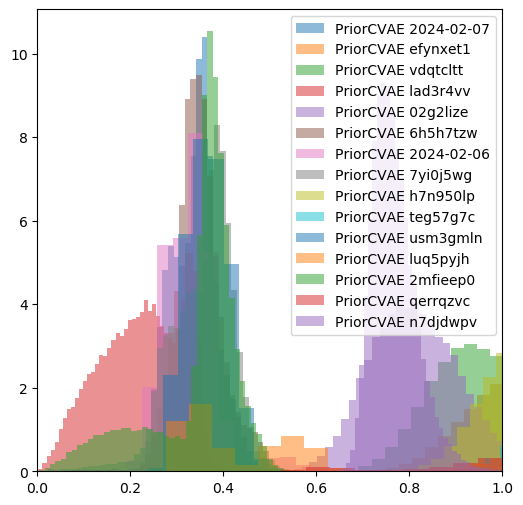

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

#plt.hist(ls_prior_draws, density=True, bins=50, alpha=0.5, color="tab:red", label='prior')
#plt.hist(c_samps_gp, density=True, bins=50, alpha=0.5, color="tab:orange", label='GP')

#for i in range(len(c_samps_cvae_lst)):
for i in range(15):
    plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, label='PriorCVAE ' + dirs[i])

plt.legend()
plt.xlim(0, 1.)
plt.show()

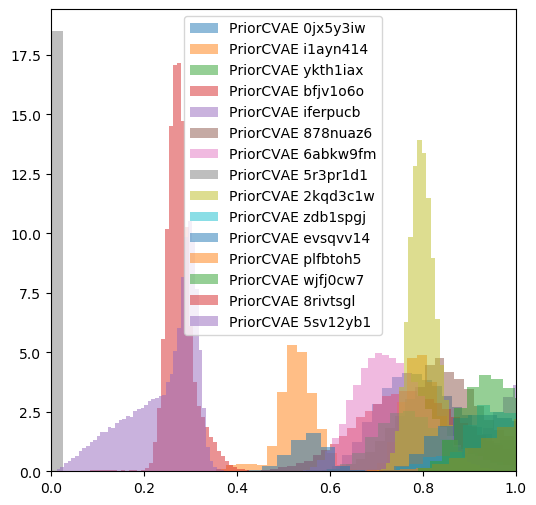

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
for i in range(15, 30):
    plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, label='PriorCVAE ' + dirs[i])

plt.legend()
plt.xlim(0, 1.)
plt.show()

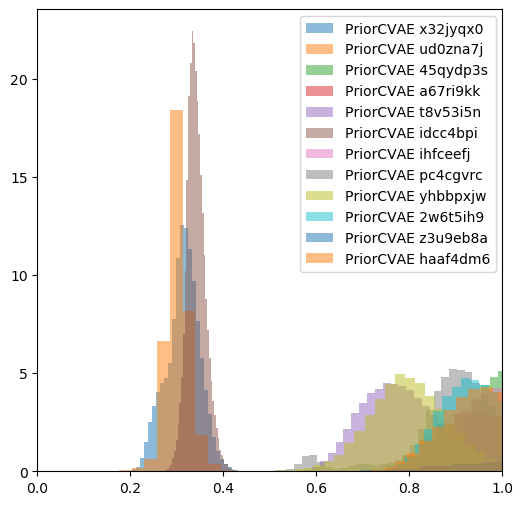

In [19]:

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
for i in range(30, len(c_samps_cvae_lst)):
    #plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, color="tab:blue", label='PriorCVAE')
    plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, label='PriorCVAE ' + dirs[i])

plt.legend()
plt.xlim(0, 1.)
plt.show()

In [20]:
def make_kde(data):
    density = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 200)
    y_vals = density(x_vals)

    return x_vals, y_vals

['#101C4B', '#7A7C3A', '#CBB598', '#0B3FDE', '#B4D177', '#782326', '#F270AB', '#34AF87', '#B792FC', '#17F43C', '#8A18AD', '#A4A55E', '#8CF58A', '#740705', '#1D5CD0', '#179955', '#AF4168', '#59F8B6', '#4C920B', '#6928A6', '#16BD30', '#075E6A', '#3DD9AF', '#A5FB2C', '#CA2DFC', '#AFDD7B', '#8769BD', '#CF1DA3', '#0CFAF3', '#61F34C', '#211357', '#9FCA6D', '#842BAB', '#4BF453', '#64E6FF', '#DAB6BC', '#053220', '#25E781', '#9C1FE1', '#C72636', '#D44E41', '#F570EC']


(0, 1.0)

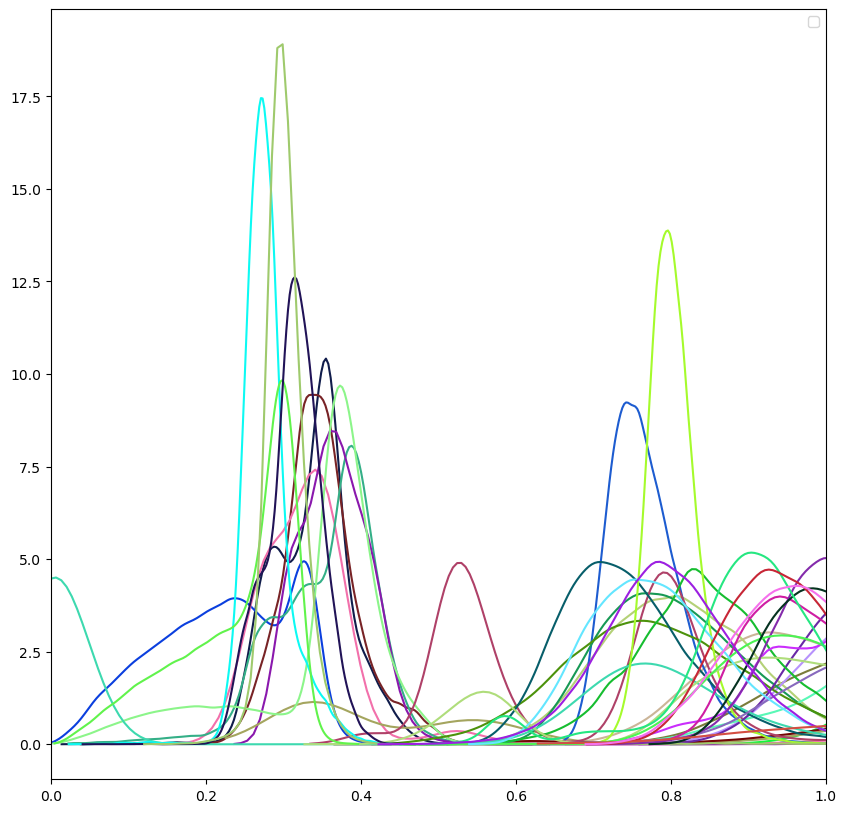

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

number_of_colors = len(c_samps_cvae_lst)

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
print(colors)

for i in range(len(c_samps_cvae_lst)):
    x_vals, y_vals = make_kde(c_samps_cvae_lst[i])
    if np.sum(y_vals > 20) == 0:
        #plt.plot(x_vals, y_vals, 'r', label='PriorCVAE ' + dirs[i], color=colors[i])
        plt.plot(x_vals, y_vals, 'r', color=colors[i])

plt.legend()
plt.xlim(0, 1.)

In [82]:
#fig, axs = plt.subplots(1, 1, figsize=(8, 8))

#x_vals, y_vals = make_kde(ls_prior_draws)
#plt.plot(x_vals, y_vals, 'r', label='prior', color="tab:red")
#plt.fill_between(x_vals, 0, y_vals, color="tab:red", alpha=0.3)

#x_vals, y_vals = make_kde(c_samps_gp)
#plt.plot(x_vals, y_vals, 'r', label='GP posterior', color="tab:orange")
#plt.fill_between(x_vals, 0, y_vals, color="tab:orange", alpha=0.3)

#colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
#colors = list(np.random.choice(range(256), size=len(c_samps_cvae_lst)))

#for i in range(len(c_samps_cvae_lst)):
#    x_vals, y_vals = make_kde(c_samps_cvae_lst[i])
#    #plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, label='PriorCVAE ' + dirs[i])
#    plt.plot(x_vals, y_vals, 'r', label='PriorCVAE ' + dirs[i], color=colors[i])

#plt.legend()
#plt.xlim(0, 1.)

## Specific model

### Model 1

In [87]:
#dir_paths

# '../../outputs/wuhdr96j'
# '../../outputs/vmp2r78b'

/opt/anaconda3/envs/prior_cvae/lib/python3.10/site-packages/matplotlib/colors.py:532: RuntimeWarning: invalid value encountered in cast
  xa = xa.astype(int)
/opt/anaconda3/envs/prior_cvae/lib/python3.10/site-packages/matplotlib/colors.py:532: RuntimeWarning: invalid value encountered in cast
  xa = xa.astype(int)
/opt/anaconda3/envs/prior_cvae/lib/python3.10/site-packages/matplotlib/colors.py:532: RuntimeWarning: invalid value encountered in cast
  xa = xa.astype(int)
/opt/anaconda3/envs/prior_cvae/lib/python3.10/site-packages/matplotlib/colors.py:532: RuntimeWarning: invalid value encountered in cast
  xa = xa.astype(int)
/opt/anaconda3/envs/prior_cvae/lib/python3.10/site-packages/matplotlib/colors.py:532: RuntimeWarning: invalid value encountered in cast
  xa = xa.astype(int)
/opt/anaconda3/envs/prior_cvae/lib/python3.10/site-packages/matplotlib/colors.py:532: RuntimeWarning: invalid value encountered in cast
  xa = xa.astype(int)
/opt/anaconda3/envs/prior_cvae/lib/python3.10/site-p

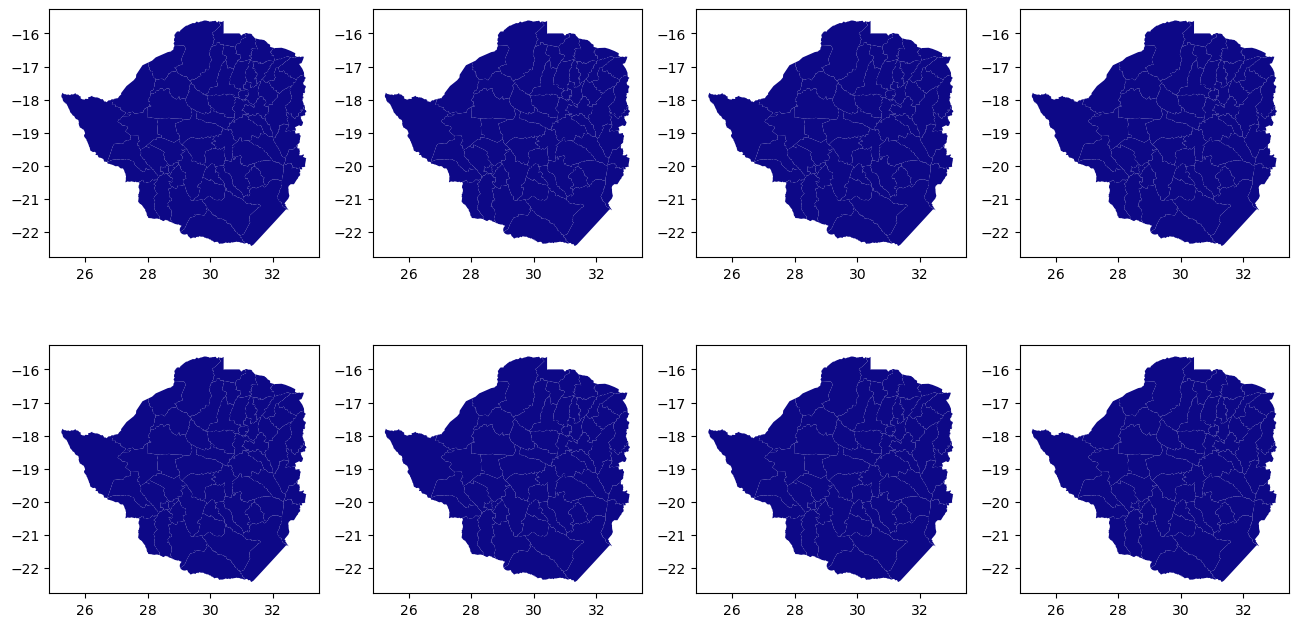

In [33]:
output_dir = '../../outputs/an8xbohc'

trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))

cvae_predictive = Predictive(model_cvae, num_samples=100)
cvae_preds_map  = cvae_predictive(rng_key_, trained_decoder_params, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), 
                                  lengthscale = 0.1)

gp_predictive = Predictive(model_gp, num_samples=100)
gp_preds_map  = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs), lengthscale = 0.1)

cvae_preds_map_f = cvae_preds_map['f']
gp_preds_map_f   = gp_preds_map['re_std']

_max = np.max([cvae_preds_map_f, gp_preds_map_f])
_min = np.min([cvae_preds_map_f, gp_preds_map_f])

fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    rows = int(i//4)
    cols = int(i%4)
    
    data['f' + str(i)] = cvae_preds_map_f[i, :]

    data.plot(column='f' + str(i),   ax=axs[rows][cols], cmap='plasma', vmin=_min, vmax =_max)


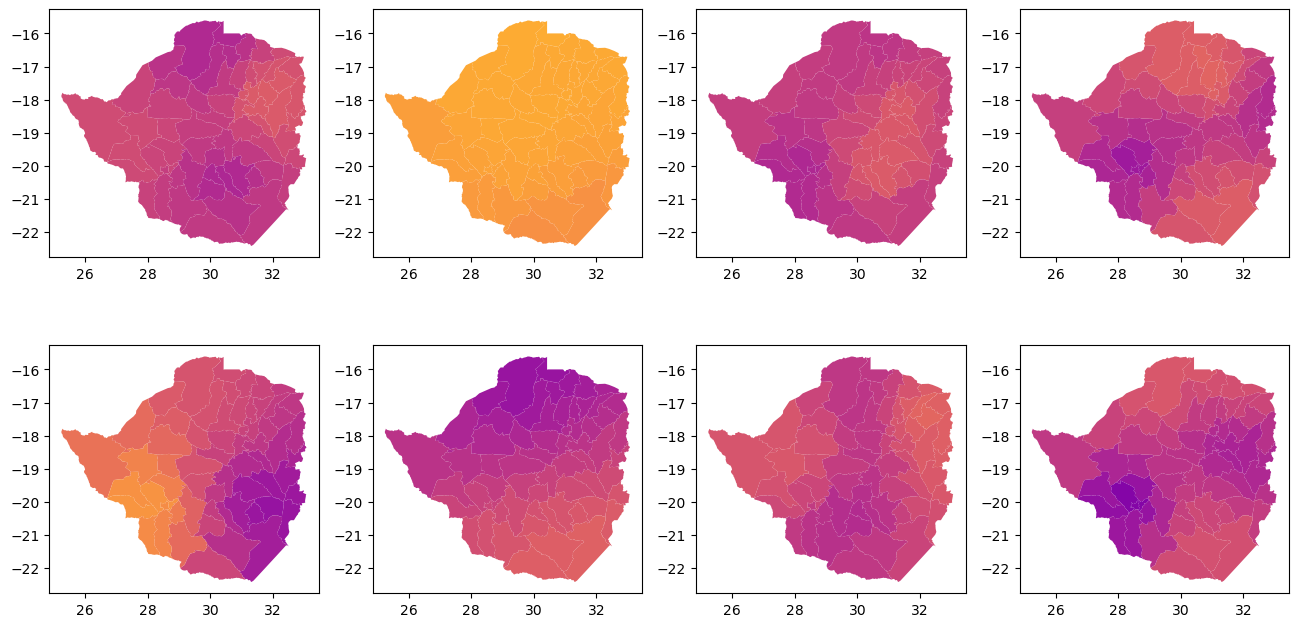

In [93]:
output_dir = '../../outputs/vmp2r78b'

trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))

cvae_predictive = Predictive(model_cvae, num_samples=100)
cvae_preds_map  = cvae_predictive(rng_key_, trained_decoder_params, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), 
                                  lengthscale = 0.1)

gp_predictive = Predictive(model_gp, num_samples=100)
gp_preds_map  = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs), lengthscale = 0.1)

cvae_preds_map_f = cvae_preds_map['f']
gp_preds_map_f   = gp_preds_map['re_std']

_max = np.max([cvae_preds_map_f, gp_preds_map_f])
_min = np.min([cvae_preds_map_f, gp_preds_map_f])

fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    rows = int(i//4)
    cols = int(i%4)
    
    data['f' + str(i)] = cvae_preds_map_f[i, :]

    data.plot(column='f' + str(i),   ax=axs[rows][cols], cmap='plasma', vmin=_min, vmax =_max)